# Use this notebook to serialize/export models to ONNX

In [1]:
import pandas as pd
import numpy as np

# load the results
df = pd.read_csv(
    "results.txt", 
    quotechar="'",
    index_col=False, 
    delim_whitespace=True,
    usecols=['Sport', 'Service', 'Style', 'Type', 'y', 'ModelType', 'Params'],
)

# drop everything after the seperator
seperator_idx = np.where(df['Sport'].str.startswith('*'))[0][0]
df = df.iloc[:seperator_idx]

with pd.option_context('max_rows', 1000, 'max_columns', 100, 'max_colwidth', 100):
    display(df)

,Sport,Service,Type,Style,y,ModelType,Params
0,nhl,draftkings,FIFTY_FIFTY,classic,top,automl-pca,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null, ""n_components"": 5}"
1,nhl,draftkings,FIFTY_FIFTY,classic,last,automl-pca,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null, ""n_components"": 5}"
2,nhl,draftkings,GPP,classic,top,automl,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null}"
3,nhl,draftkings,GPP,classic,last,automl-pca,"{""train_time"": 120, ""per_run_time"": 30, ""model_cols"": null, ""n_components"": 5}"
4,nhl,fanduel,GPP,classic,top,automl,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null}"
5,nhl,fanduel,FIFTY_FIFTY,classic,top,automl,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null}"
6,nhl,fanduel,FIFTY_FIFTY,classic,last,automl,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null}"
7,nhl,yahoo,FIFTY_FIFTY,classic,top,automl,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": ""best-possible-score""}"
8,nhl,yahoo,GPP,classic,top,automl-pca,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": null, ""n_components"": 5}"
9,nhl,yahoo,GPP,classic,last,automl,"{""train_time"": 600, ""per_run_time"": 120, ""model_cols"": ""best-possible-score""}"


Exporting model 'nhl_draftkings_classic_FIFTY_FIFTY_automl-pca'
loading filename='nhl-draftkings-CLASSIC-FIFTY_FIFTY.csv'
127 rows of data loaded
dropping 4 rows due to nan_slate_rows=2 nan_best_score_rows=2
Training model...
nhl_draftkings_classic_FIFTY_FIFTY_automl-pca: model_cols=None
R2 score: 0.3471783732767241
RMSE score: 18.315276186434833
MAE score: 3.8463674154267733
Exporting model to nhl_draftkings_classic_FIFTY_FIFTY_automl-pca.onnx


[('best-possible-score', DoubleTensorType(shape=[None, 1])),
 ('team_count', DoubleTensorType(shape=[None, 1])),
 ('team-med', DoubleTensorType(shape=[None, 1])),
 ('team-70.0th_pctl', DoubleTensorType(shape=[None, 1])),
 ("('med-dfs', 'C')", DoubleTensorType(shape=[None, 1])),
 ("('med-dfs', 'D')", DoubleTensorType(shape=[None, 1])),
 ("('med-dfs', 'G')", DoubleTensorType(shape=[None, 1])),
 ("('med-dfs', 'W')", DoubleTensorType(shape=[None, 1])),
 ("('70.0th-pctl-dfs', 'C')", DoubleTensorType(shape=[None, 1])),
 ("('70.0th-pctl-dfs', 'D')", DoubleTensorType(shape=[None, 1])),
 ("('70.0th-pctl-dfs', 'G')", DoubleTensorType(shape=[None, 1])),
 ("('70.0th-pctl-dfs', 'W')", DoubleTensorType(shape=[None, 1]))]

RuntimeError: For operator SklearnPCA (type: SklearnPCA), at most 1 input(s) is(are) supported but we got 12 output(s) which are ['best_possible_score', 'team_count', 'team_med', 'team_70_0th_pctl', '__med_dfs____C__', '__med_dfs____D__', '__med_dfs____G__', '__med_dfs____W__', '__70_0th_pctl_dfs____C__', '__70_0th_pctl_dfs____D__', '__70_0th_pctl_dfs____G__', '__70_0th_pctl_dfs____W__']

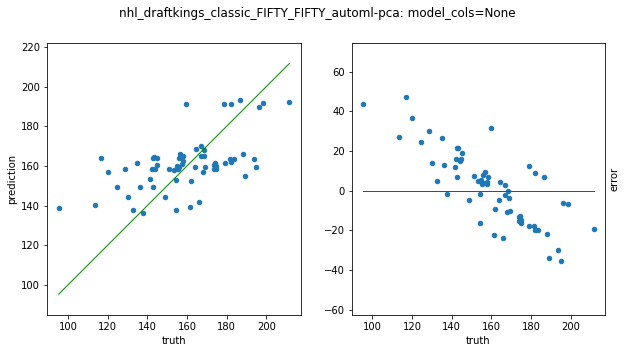

In [6]:
import json

from skl2onnx import convert_sklearn
import numpy as np
from skl2onnx.common.data_types import FloatTensorType

import fantasy_py.lineup.strategy
from fantasy_py import ContestStyle, CLSRegistry, CONTEST_DOMAIN

from automl import automl, error_report, get_df_types
from generate_train_test import generate_train_test, load_csv


PCA_COMPONENTS = 5


for idx, row in df.iterrows():
    contest_style = ContestStyle[row.Style.upper()]
    contest_type = CLSRegistry.get_class(CONTEST_DOMAIN, row.Type)
    full_model_name = f'{row.Sport}_{row.Service}_{contest_style}_{row.Type}_{row.ModelType}'
    print(f"Exporting model '{full_model_name}'")
    
    data_df = load_csv(row.Sport, row.Service, contest_style, contest_type)
    
    model_def = json.loads(row.Params)
    
    (X_train, X_test, y_top_train, y_top_test,
     y_last_win_train, y_last_win_test) = generate_train_test(
        data_df,
        model_cols=model_def['model_cols'],
        random_state=5,
    )
    
    if row.ModelType == 'automl-pca':
        pca_components = PCA_COMPONENTS
    elif row.ModelType == 'automl':
        pca_components = None
    else:
        raise ValueError(f"Don't know how to process model type {row.ModelType}")
    
    if row.y == 'top':
        y_train = y_top_train
        y_test = y_top_test
        model_name = 'top-score'
    elif row.y == 'last':
        y_train = y_last_win_train
        y_test = y_last_win_test
        model_name = 'last-win-score'
    else:
        raise ValueError(f"Unexpected y of {row.y}")
       
    sk_model, fit_params = automl(
        model_name, 
        train_time=30, # model_def['train_time'],
        per_run_time_limit=2, # model_def['per_run_time'],
        seed=1,
        overwrite=True,
        pca_components=pca_components,
    )
    print("Training model...")
    sk_model.fit(X_train, y_train, **fit_params)
    error_report(sk_model, X_test, y_test, 
                 full_model_name + f": model_cols={model_def['model_cols']}")
    
    print(f"Exporting model to {full_model_name}.onnx")
    df_types = get_df_types(X_train)
    display(df_types)
    onnx_model = convert_sklearn(sk_model, model_name, 
                                 df_types,
                                 final_types=[('variable1',FloatTensorType([1,1]))])
    with open(full_model_name + ".onnx", "wb") as f:
        f.write(onnx_model.SerializeToString())


print("Done!")